# SIFT and SVM

### Packages

In [1]:
import numpy as np 
import pandas as pd
from sklearn import svm
import cv2
import csv
import os
from os import listdir
from os.path import isfile, join
import glob
from sklearn import cluster
from scipy.misc import *
import skimage.measure as sm
# import progressbar
import matplotlib.pyplot as plt
from subprocess import check_output
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler

### File Loading

In [2]:
def load_paths():
    #print('----Check output----\n', check_output(["ls", "./train/"]).decode("utf8"))

    # Any results you write to the current directory are saved as output.
    dir_names = [d for d in listdir("./train/") if not isfile(join("./train/", d))]
    #print('\n ----Subdirectories----\n', dir_names)

    #file_paths contains the file names for each category
    #key has format: (Category,CatNumber,Path)
    file_paths = {}
    class_num = 0
    cat_int = {}
    int_cat = {}
    prediction_output_list=[]
    test_names=[f for f in listdir("./test_stg1/") if isfile(join("./test_stg1", f))]
    train_path = './train'
    training_names = os.listdir(train_path)
    for d in dir_names:
        fnames = [f for f in listdir("./train/"+d+"/") if isfile(join("./train/"+d+"/", f))]
        file_paths[(d, class_num, "./train/"+d+"/")] = fnames
        cat_int[d]=class_num
        int_cat[class_num]=d
        class_num += 1
    return fnames, file_paths, cat_int, int_cat, training_names, train_path, test_names


fnames, file_paths, cat_int, int_cat, training_names, train_path, test_names=load_paths()    

In [4]:
def load_images(path,names,k=-1):
    if k==-1:
        k=1000000
    image_paths = []
    image_classes = []
    class_id = 0
    for name in names:
        dir = os.path.join(path, name)
        class_path = [dir+'/'+f for f in listdir(dir) if isfile(join(dir, f))]
        class_path=class_path[:k]
        image_paths+=class_path
        image_classes+=[class_id]*len(class_path)
        class_id+=1
    return image_paths, image_classes

image_paths, image_classes=load_images(train_path,training_names,k=-1)

### SIFT Extraction

In [5]:
def SIFT_extractor(image_paths):
    detector = cv2.xfeatures2d.SIFT_create()

    des_list = []

    print('Total: ', len(image_paths))
    count=0

    print('----')
    for image_path in image_paths:
        im = cv2.imread(image_path,0)
        im = cv2.resize(im, (400, 250))
        kpts, des = detector.detectAndCompute(im, None)
        des_list.append((image_path, des))   
        if count%(int(len(image_paths)/10))==0:
            print(round(count/len(image_paths)*100), '%')
        count=count+1
    print('----')
    return des_list

#des_list=SIFT_extractor(image_paths)

Total:  3777
----
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
----


In [6]:
def transform_descriptors(des_list,image_classes):
    descriptors=[]
    labels=[]
    count=1
    for dd in des_list[1:]:
        l=image_classes[count]
        count=count+1
        for d in dd[1]:
            descriptors.append(d)
            labels.append(l)

    descriptors=np.array(descriptors)
    return  descriptors, labels


descriptors, labels=transform_descriptors(des_list,image_classes)

CPU times: user 1.17 s, sys: 76 ms, total: 1.25 s
Wall time: 1.25 s


#### Optional Plotting

In [9]:
%matplotlib inline

if False:
    from sklearn.decomposition import PCA

    feat_PCA=PCA(n_components=10)
    descriptors2=feat_PCA.fit_transform(descriptors)
    
#Plotting
if False:
    from random import *
    col={}
    for k in np.unique(labels):
        col[k]=(random()<1/2, random()<1/2, random()<1/2)

    x_plot=[x[0] for x in descriptors2]
    y_plot=[x[1] for x in descriptors2]
    col_labels=[col[l] for l in labels]
    print(np.shape(image_classes))
    plt.scatter(x_plot,y_plot, c=col_labels, label=labels)
    plt.legend(bbox_to_anchor=(1.2, 1),
            bbox_transform=plt.gcf().transFigure);
    plt.show()

### Bag of Features construction

#### K-Means

In [9]:
%%time

# Perform k-means clustering
from sklearn.cluster import KMeans

def create_voc(descriptors,k=100):
    km=KMeans(k)
    #km.fit(descriptors)
    voc,_=kmeans(descriptors,k)
    #voc=km.cluster_centers_
    return voc

voc=create_voc(descriptors,k=10)

CPU times: user 20min 42s, sys: 34.1 s, total: 21min 16s
Wall time: 13min 20s


#### Histogram

In [12]:
def trsf_BoF(des_list, voc):
    # Calculate the histogram of features
    im_features = np.zeros((len(des_list),len(voc)), "float32")
    for i in range(len(des_list)):
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1
    # Perform Tf-Idf vectorization
    nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
    idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

    # Scaling the words
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)
    return im_features

#im_features=trsf_BoF(des_list,voc)

#### Classifier

In [14]:
if False:
    # Train the Linear SVM
    clf = SVC(probability=True)
    clf.fit(im_features, np.array(image_classes))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Optional Plotting

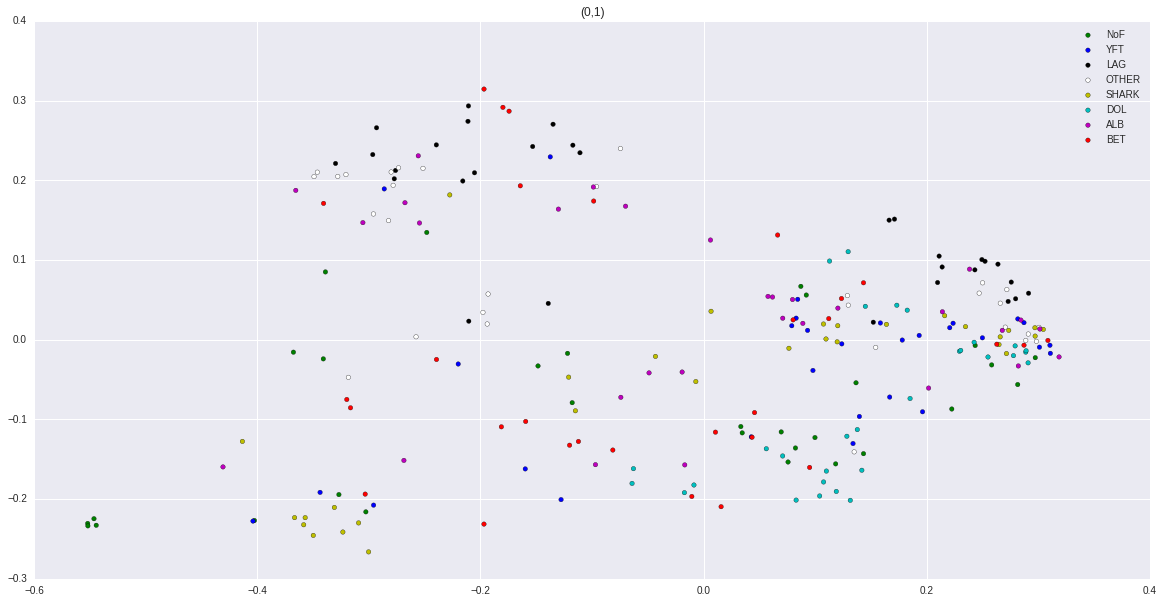

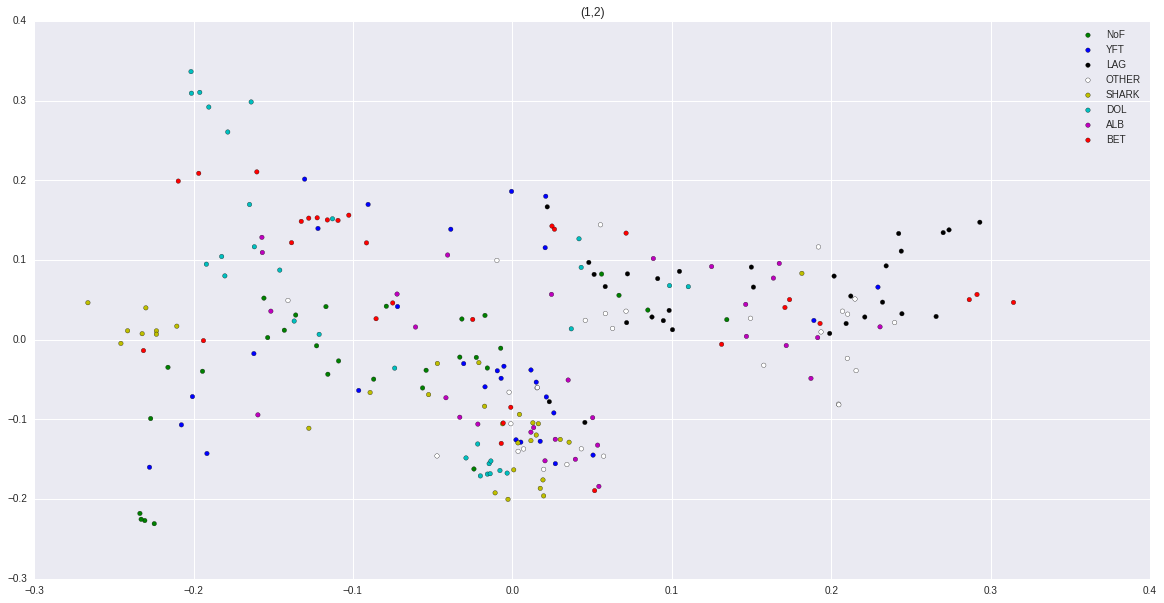

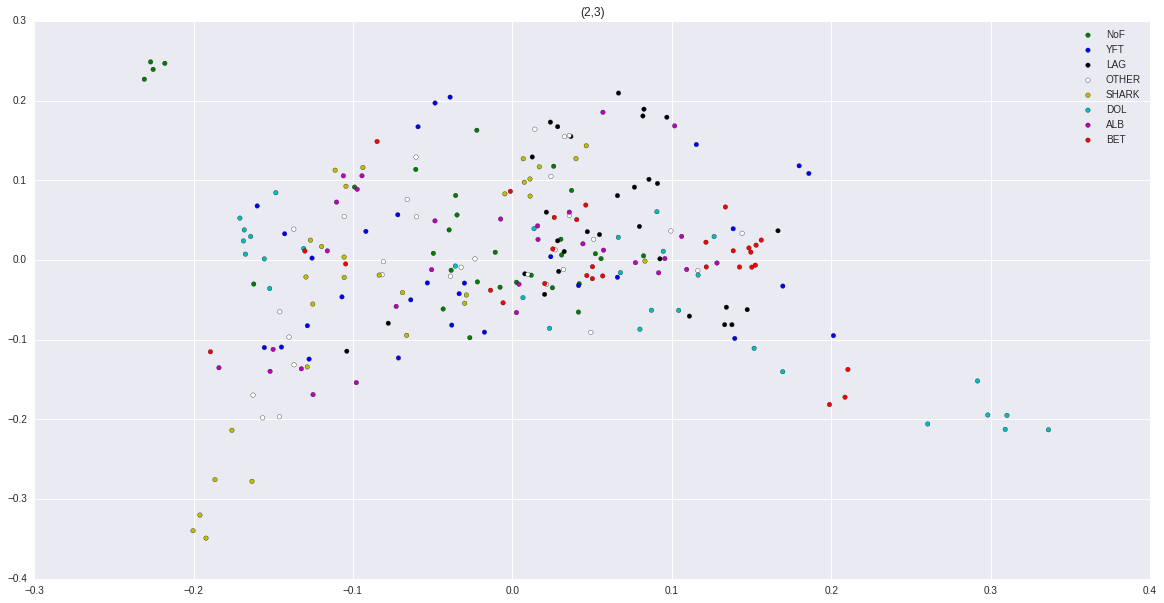

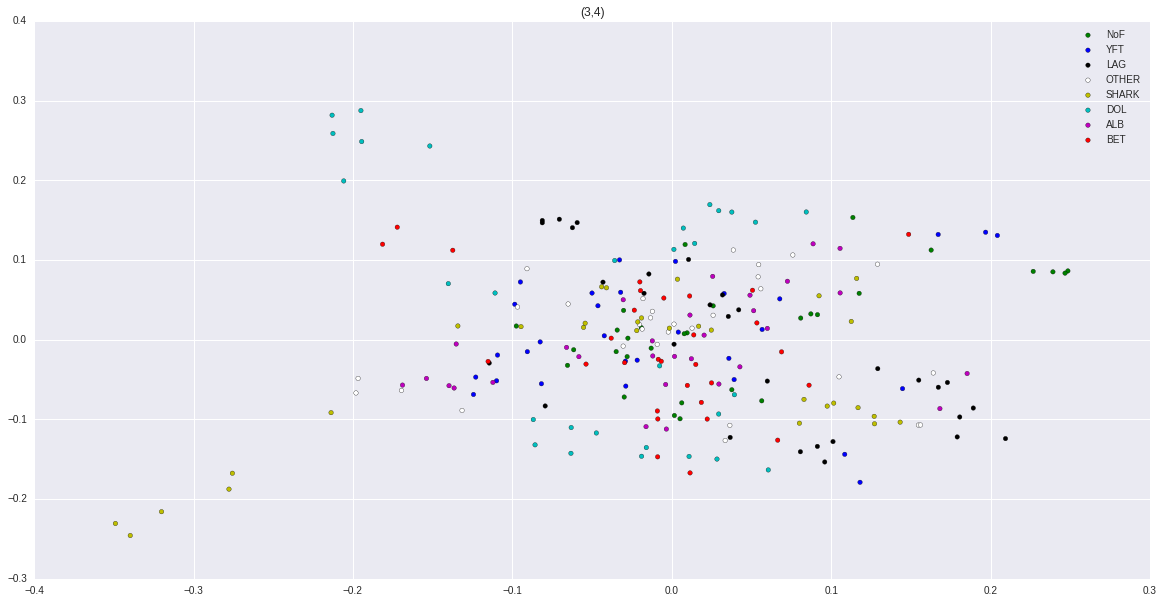

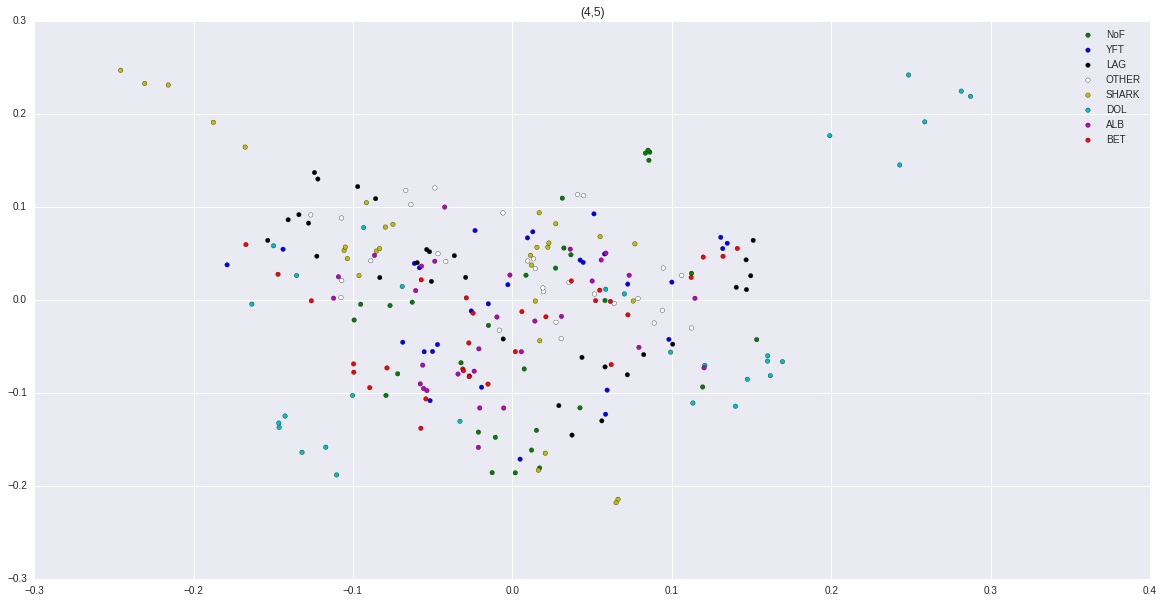

In [99]:
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

col={0:'g',
     1:'b',
     2:'k',
     3:'w',
     4:'y',
     5:'c',
     6:'m',
     7:'r'
}

feat_PCA=KernelPCA(n_components=10,kernel='rbf')
descriptors2=feat_PCA.fit_transform(im_features)

for i in range(5):
    fig=plt.figure(figsize=(20,10))
    for m in np.unique(image_classes):
        ind=image_classes==m
        x_plot=[x[i] for x in descriptors2[ind]]
        y_plot=[x[i+1] for x in descriptors2[ind]]
        col_labels=[col[l] for l in image_classes[ind]]
        plt.scatter(x_plot,y_plot, c=col_labels, label=int_cat[m])
    plt.legend()
    plt.title('(%i,%i)'%(i,i+1))
    plt.show()

#### Write Submission

In [17]:
def result_to_csv(output_name, result):
    try:
        with open(output_name+".csv", "w") as f:
            writer = csv.writer(f)
            f.flush()
            headers = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT','image']
            #headers= "image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT"
            writer.writerow(headers)
            writer.writerows(result)
    finally:
        f.close()

### Main Algorithm

**Warning: **
The algorithm is quite long to run:
- SIFT Extraction: ~ 5 minutes
- K-Means: ~ 30 minutes for nb_img x k x SIFT_dim = 3777 x 50 x 128

In order to reduce computation time, it is possible to split the initial sample of images into K subsamples and build $\frac{k}{K}$ clusters on it. Finally they are aggregated to build a complete vocabulary.

In [20]:
%%time

def main(nb_split=10, nb_features=10,output_name='submission', CV=False):
    #Load paths
    fnames, file_paths, cat_int, int_cat, training_names, train_path, test_names=load_paths()    
    image_paths, image_classes=load_images(train_path,training_names)
    
    #Shuffle and split images
    zz=np.array([[image_classes[i], image_paths[i]] for i in range(len(image_classes))])
    np.random.shuffle(zz)
    image_paths=zz.T[1] 
    image_classes=zz.T[0]
    list_img=np.array_split(image_paths,nb_split)
    
    #Extract SIFT and build vocabulary
    voc=[]
    des_list=[]
    it=1
    for sublist in list_img:
        print('Extraction: %i / %i'%(it,len(list_img)))
        des=SIFT_extractor(sublist)
        des_list.append(des)
        descriptors, _=transform_descriptors(des,sublist)
        print('KMeans for features')
        voc.append(create_voc(descriptors,k=int(nb_features/nb_split))
        it=it+1
        print('-----------------')
    #Aggregation
    voc_tot=np.vstack(voc)
    des_tot=[]
    for i in range(len(des_list)):
        des_tot=des_tot+des_list[i]
    
    #Build histogram
    print('Histogram building')
    im_features=trsf_BoF(des_tot,voc_tot)
    print('-----------------')
    
    #Fit SVC
    print('Training of classifier')
    clf = SVC(probability=True)
    if CV:
        tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
        clf=GridSearchCV(clf,tuned_parameters, cv=5)
    clf.fit(im_features, np.array(image_classes))
    print('-----------------')
    
    #Test application
    print('Test')
    test_paths=['./test_stg1/'+t for t in test_names]
    print('---------------')
    print('SIFT extraction')
    print('---------------')
    des_test=SIFT_extractor(test_paths)
    test_features= trsf_BoF(des_test,voc_tot)
    output_proba=clf.predict_proba(test_features)
    result_write=[output_proba[i].tolist()+[test_names[i]] for i in range(len(test_names))]
    result_to_csv(output_name, result_write)
    return im_features, np.array(image_classes)
    
im_features, image_classes=main(1,200,'submission', False)

Extraction: 1 / 1
Total:  3777
----
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
----
KMeans for features
-----------------
Histogram building
-----------------
Training of classifier
-----------------
Test
---------------
SIFT extraction
---------------
Total:  1000
----
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
----
CPU times: user 4h 14min 45s, sys: 12min 32s, total: 4h 27min 18s
Wall time: 2h 39min 55s


### Difference of Gaussian

Nice plot of the first step of the SIFT algorithm

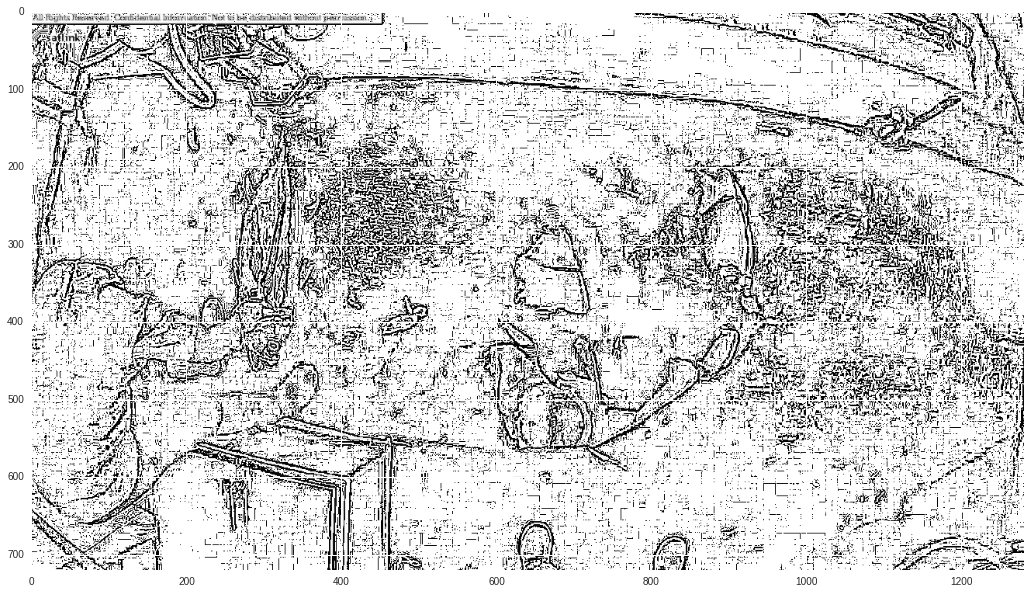

In [104]:
img = cv2.imread('./test_stg1/img_00075.jpg', 0)  #= imread("test.png", CV_LOAD_IMAGE_COLOR); 
g1=cv2.GaussianBlur(img, (1,1), 0);
g2=cv2.GaussianBlur(img, (5,5), 0);
result = g1 - g2;
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()